# Projet 7 : Réalisez des indexations automatiques d’images
# <u>B. Classification des images avec méthodes supervisées</u> <br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import  KNeighborsClassifier

from glob import glob
import scipy
from scipy.misc import imread

import cv2

from skimage import img_as_ubyte

warnings.filterwarnings("ignore")

In [2]:
print('OpenCV Version',cv2.__version__)

OpenCV Version 3.4.1


# 1. Préparation des données

## 1.1 Configuration des noms de répertoires

In [3]:
DATA_DIR = 'data'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

Les images sont chargées à partir du chemin spécifié.<br/>
Les images doivent être rangés dans un dossier dont le nom contient la race correspondante<br/>
 \- breed<br/>
&nbsp;&nbsp;&nbsp;      \--- image 1 <br/>
&nbsp;&nbsp;&nbsp;      \--- image 2<br/>

## 1.2 Chargement des images

In [4]:
'''
retourne une liste contenant les images et une autre liste avec la race de chaque image.
'''
def loadDogsImagesData(path):
    imlist = []
    labels = []
    for each in glob(path + "*"):
        if not(os.path.isdir(each)):
            continue
        breed_name = each.split("/")[-1].split('-')[1]
        print (" #### Reading breed category ", breed_name, " ##### ")
        for imagefile in glob(each+"/*"):
            im = cv2.imread(imagefile)
            imlist.append(im)
            labels.extend([breed_name])
    return [imlist,labels]

- Chargement des données d'entrainement

In [5]:
train_images,  train_breed_names = loadDogsImagesData(TRAIN_DIR +'/' )

 #### Reading breed category  Siberian_husky  ##### 
 #### Reading breed category  Maltese_dog  ##### 
 #### Reading breed category  Chihuahua  ##### 
 #### Reading breed category  Scotch_terrier  ##### 
 #### Reading breed category  Irish_setter  ##### 


- Chargement des données de test.

In [6]:
test_images,  test_breed_names = loadDogsImagesData(TEST_DIR +'/' )

 #### Reading breed category  Siberian_husky  ##### 
 #### Reading breed category  Maltese_dog  ##### 
 #### Reading breed category  Chihuahua  ##### 
 #### Reading breed category  Scotch_terrier  ##### 
 #### Reading breed category  Irish_setter  ##### 


## 1.3 Numérisation de la race des chiens (Label encoder)

Il nous faut transformer les races de chiens (variable catégorielle) en donnée numérique.<br/>
Pour celà nous utilisons la classe LabelEncoder

In [7]:
breed_names = set(train_breed_names)
breed_names = list(breed_names)
breed_label_encoder = LabelEncoder()
breed_label_encoder.fit(breed_names)

LabelEncoder()

Préparation des données cibles d'entrainement et de test.

In [8]:
train_breeds =  breed_label_encoder.transform(train_breed_names)
test_breeds =  breed_label_encoder.transform(test_breed_names)

In [9]:
print("Nombre images entrainement", len(train_breeds))
print("Nombre images tests", len(test_breeds))

Nombre images entrainement 120
Nombre images tests 30


In [10]:
'''
Méthode qui retourne le nom de la race associé à la valeur numérique
'''
def decodeLabel(num_label) :
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    l = breed_label_encoder.inverse_transform(num_label)
    warnings.resetwarnings()
    return l

## 1.4 Jeu d'entrainement et de tests

Nous créons un dataframe pour stocker les jeux de données.<br>
Le dataframe sera composé de 3 colonnes : <br>
    - L'image du wouaf wouaf
    - La race du chien en valeur numérique
    - La race du chien textuelle

In [11]:
train_df = pd.DataFrame({'Image':np.array(train_images), 'BreedIdx':train_breeds, 'BreedName':train_breed_names})

In [12]:
test_df = pd.DataFrame({'Image':np.array(test_images), 'BreedIdx':test_breeds, 'BreedName':test_breed_names})

In [13]:
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (120, 3)
Test: (30, 3)


# 2. Méthodes pour traitement des images

## 2.1 Preprocessing

Quelques méthodes de pré-traitement des images.

In [14]:
'''
Equalisation de l'histogramme
'''
def equalizeHist(colored_img):
    img_yuv = cv2.cvtColor(colored_img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_trans = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_trans

In [15]:
'''
Filtre glaussian blur
'''
def gaussianBlur(colored_img) :
    blur = cv2.GaussianBlur(colored_img,(5,5),0)
    return blur

In [16]:
'''
On essaye de détourer l'image du chien
'''
def grabCut(colored_img) :  
    mask = np.zeros(colored_img.shape[:2],np.uint8)
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    nb_iter = 2

    rect = (1,1,colored_img.shape[1]-1,colored_img.shape[0]-1)
    cv2.grabCut(colored_img,mask,rect,bgdModel,fgdModel,nb_iter,cv2.GC_INIT_WITH_RECT)

    fgd_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_grabcut = colored_img*fgd_mask[:,:,np.newaxis]
    return img_grabcut

In [17]:
'''
Applique les traitements listés dans 'preprocessing' aux images.
'''
def preprocess_images(images_list, preprocessing) :
    X_trans=[]
    for im in images_list:
        for p in preprocessing :
            im_trans = im
            if p == 'EqualizeHistogram' :
                im_trans = equalizeHist(im)
            elif p == 'GaussianBlur' :
                im_trans = gaussianBlur(im)
            elif p == 'GrabCut' :
                im_trans = grabCut(im)
            else :
                print("Error unknown processing : ", p)
        X_trans.append(im_trans)
    return X_trans

## 2.2 Extraction des features

- On utilise la méthode SIFT pour extraire les features des images
- On va extraire les points clés (keypoints) et les descripteurs.

In [18]:
def extract_features(color_img) :
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    # desc is the SIFT descriptors
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [19]:
'''
 Extraction des features pour une liste d'images (format binaire)
'''
def getFeatures(images_list) :
    descriptor_list = []
    for im in images_list:
        kp, des = extract_features(im)
        descriptor_list.append(des)
    return descriptor_list

## 2.3 Affichage

Pour l'affichage de l'image.

In [20]:
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

# 3. Prise en main classification Visual Bag Of Words

Dans cette partie, nous commençons par appliquer les différentes étapes de notre classification sur un échantillon de donnée.<br/>
Nous allons ensuite appliquer le tuning et tester différents modèles de classification dans la partie suivante.<br/>
- extraction des features
- clustering des features
- pour chacune des images, on établit l'histogramme par cluster
- on y entraine ensuite un algo de classification
- on fait les prédictions sur le jeu de test.

## 3.1 Common methods

- Clustering des features

In [21]:
def getBagOfFeatures(no_clusters, descriptor_list) :
    descriptor_matrix = np.vstack( descriptor_list)
    start_time = time()
    kmeans = KMeans(n_clusters = no_clusters)
    bag_of_features = kmeans.fit_predict(descriptor_matrix)
    print("elapsed time =", time() - start_time)
    return bag_of_features, kmeans

- Histogramme de cluster pour nos images.

In [22]:
def getFrequencyOfVisualWords(no_clusters, num_images, descriptor_list,bag_of_features ) :
    # contains the frequency of occurence of each visual word 
    img_bow_hist = np.array([np.zeros(no_clusters) for i in range(num_images)])
    indice = 0
    for i in range(num_images):
        l = len(descriptor_list[i])
        for j in range(l):
            cluster_idx = bag_of_features[indice+j]
            img_bow_hist[i][cluster_idx] += 1
        indice += l 
    # standardize 
    scale = StandardScaler().fit(img_bow_hist)
    img_bow_hist = scale.transform(img_bow_hist)
    return img_bow_hist, scale

## 3.2 Apprentissage

On prend un échantilon de nos données (100 images pour entrainement et 20 pour test)

In [23]:
train_sample = train_df.sample(100)
test_sample = test_df.sample(20)

### Image preprocessing et SIFT Features

In [24]:
images = train_sample['Image']

In [25]:
descriptors = getFeatures(images)

### Clustering

In [26]:
no_cluster = 10
bow, kmeans = getBagOfFeatures(no_cluster, descriptors)

elapsed time = 13.100451946258545


### Histogramme par cluster des images

On standardise le résultat.

In [27]:
img_bow_hist, scale = getFrequencyOfVisualWords(no_cluster, len(images), descriptors, bow)

### Entrainement du classifier

In [28]:
clf  = SVC()
clf.fit(img_bow_hist, train_sample['BreedIdx'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 3.3 Validation avec données de test

On prépare les données de test en faisant l'extraction des features, en détérminant les clusters, puis pour chaque image, l'histogramme par cluster.
On teste ensuite nos prédictions.

In [29]:
test_images = test_sample['Image']
test_descriptors = getFeatures(test_images)
test_clusters = kmeans.predict(np.vstack( test_descriptors) )
vocabs = np.array([np.zeros(no_cluster) for i in range(test_sample['Image'].shape[0])])
indice = 0
for i in range(test_sample['Image'].shape[0]):
    l = len(test_descriptors[i])
    for j in range(l):
        cluster_idx = test_clusters[indice+j]
        vocabs[i][cluster_idx] += 1
    indice += l 
vocabs = scale.transform(vocabs.astype(float))

In [30]:
y_pred = clf.predict(vocabs)
y_test = test_sample['BreedIdx']

## 3.4 Evaluation

On regarde l'accuracy (% de chiens correctement classés)

In [31]:
def evaluateClassifier(y_true, y_pred) :
    print("Classification accuracy: {:.2f} % ".format(100*metrics.accuracy_score(y_true, y_pred)))

On affiche la matrice de confusion pour visualiser la pertinence de nos classement

In [32]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred, class_names) :
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [33]:
evaluateClassifier(y_test, y_pred)

Classification accuracy: 35.00 % 


Confusion matrix, without normalization


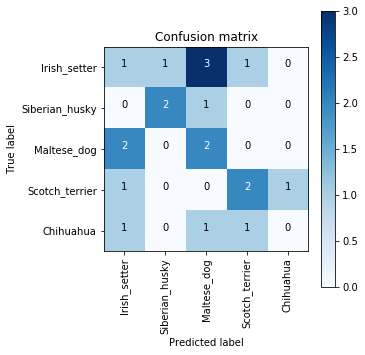

In [34]:
displayConfusionMatrix(y_test, y_pred, breed_names)

In [35]:
def evaluatePerClass(y_true, y_pred) :
    corrected_pred = [0] * len(breed_names)
    total_pred = [0] * len(breed_names)
    unique, pred = np.unique( y_pred[y_true == y_pred], return_counts=True)
    for idx, val in enumerate(unique):
        corrected_pred[val] = pred[idx]  
    unique, total = np.unique(y_true, return_counts=True)
    for idx, val in enumerate(unique):
        total_pred[val] = total[idx]  
    ratio_per_class = np.array(corrected_pred) / np.array(total_pred)
    df = pd.DataFrame({'Breed': decodeLabel(unique), 'PredictionRatio':ratio_per_class})
    df.plot.bar(x='Breed')
    display(df)

,Breed,PredictionRatio
0,Chihuahua,0.166667
1,Irish_setter,0.666667
2,Maltese_dog,0.500000
3,Scotch_terrier,0.500000
4,Siberian_husky,0.000000


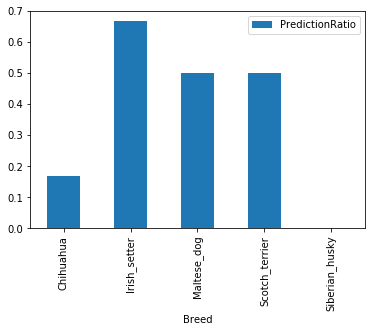

In [36]:
evaluatePerClass(y_test.values, y_pred)

# 4. Evaluation et tuning des modèles

Dans cette partie, nous allons d'abord construire un pipeline permettant d'effectuant à la fois les prétraitements, l'extraction des features, mais également les différentes transformation vues plus haut pour appliquer les algorithmes de classification.<br/>
Puis nous allons "tuner" et tester differents algorithmes de classification supervisée.

## 4.1 Pipeline pour traitement des données

- Traitement sur les images

In [37]:
class ImgPreprocessing(BaseEstimator, TransformerMixin):
    
    def __init__(self, preprocess=['EqualizeHistogram', 'GaussianBlur', 'GrabCut']) :
        self.preprocess = preprocess
        return
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None) :
        return preprocess_images(X, self.preprocess )

- Extraction des features

In [38]:
class ImgFeaturesExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self) :
        return
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None) :
        descriptors = getFeatures(X)
        return np.array(descriptors)

- Histogramme par cluster des images

In [39]:
class BagOfVisualWordsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=10 ) :
        self.n_clusters = n_clusters        

    def fit(self, X, y=None):
        X_stack = np.vstack(X)
        self.kmeans = KMeans(n_clusters = self.n_clusters)
        self.kmeans.fit(X_stack)
        return self
    

    def transform(self, X , y=None) :
        num_images = len(X)
        X_stack = np.vstack(X)
        bag_of_features = self.kmeans.predict(X_stack)
        img_bow_hist = np.array([np.zeros(self.n_clusters) for i in range(num_images)])
        indice = 0
        for i in range(num_images):
            l = len(X[i])
            for j in range(l):
                cluster_idx = bag_of_features[indice+j]
                img_bow_hist[i][cluster_idx] += 1
            indice += l
        return img_bow_hist

## 4.2 Evaluation des pré-traitements sur les images

Le prétraitement des images est assez consommateurs. Plutôt que de l'appliquer à chaque évaluation d'algorithme de classification, nous commençons par rechercher les traitements qui semblent améliorer les prédictions.<br/>
Pour celà nous allons comparer différents traitement sur notre échantillon.

In [40]:
x_train = train_sample['Image']
y_train = train_sample['BreedIdx']
x_test = test_sample['Image']
y_test = test_sample['BreedIdx']

- Nous créons le pipeline avec uniquement un traitement : GrabCut.

In [41]:
pprocess_pipeline = Pipeline(steps=[
    ('preprocess', ImgPreprocessing(preprocess=['GrabCut'])),
    ('extract', ImgFeaturesExtractor()),
    ('visualbow', BagOfVisualWordsTransformer(n_clusters=50)),
    ('scale', StandardScaler()), 
    ('classify', SVC())
])
pprocess_pipeline.fit(x_train,y_train)
y_pred = pprocess_pipeline.predict(x_test)
evaluateClassifier(y_test, y_pred)

Classification accuracy: 50.00 % 


- Nous créons le pipeline avec traitement GrabCut et Gaussion Blur.

In [42]:
pprocess_pipeline = Pipeline(steps=[
    ('preprocess', ImgPreprocessing(preprocess=['GrabCut','GaussianBlur'])),
    ('extract', ImgFeaturesExtractor()),
    ('visualbow', BagOfVisualWordsTransformer(n_clusters=50)),
    ('scale', StandardScaler()), 
    ('classify', SVC())
])
pprocess_pipeline.fit(x_train,y_train)
y_pred = pprocess_pipeline.predict(x_test)
evaluateClassifier(y_test, y_pred)

Classification accuracy: 20.00 % 


On perd en performance.

Pipeline avec traitement GrabCut et équalisation d'histogramme.

In [43]:
pprocess_pipeline = Pipeline(steps=[
    ('preprocess', ImgPreprocessing(preprocess=['GrabCut','EqualizeHistogram'])),
    ('extract', ImgFeaturesExtractor()),
    ('visualbow', BagOfVisualWordsTransformer(n_clusters=50)),
    ('scale', StandardScaler()), 
    ('classify', SVC())
])
pprocess_pipeline.fit(x_train,y_train)
y_pred = pprocess_pipeline.predict(x_test)
evaluateClassifier(y_test, y_pred)

Classification accuracy: 50.00 % 


C'est celui qui donne le meilleur score. Nous partons donc sur ces 2 traitements d'images.

## 4.3 GridSearch

Nous allons utiliser la recherche sur grille pour tuner nos algorithmes. Nous allons ensuite comparer les différents résultats.

In [44]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
Affiche les meilleurs paramètres et la précision du modèle.
'''
def evaluateClassifier(model, extra_param, x_feat_train, y_train, x_feat_test, y_test) :
    warnings.filterwarnings("ignore")
    t0 = time()
    Kfold = 5
    parameters = { 
              'visualbow__n_clusters': [50, 100, 200]
    }
    parameters.update(extra_param)
    
    classifier = Pipeline(steps=[
        ('visualbow', BagOfVisualWordsTransformer()),
        ('scale', StandardScaler()), 
        ('clf', model)
    ])
    gs_classifier = GridSearchCV(estimator = classifier, param_grid = parameters, cv = Kfold,  n_jobs=-1)
    fit = gs_classifier.fit(x_feat_train, y_train)
    print("Best params :", gs_classifier.best_params_)
    y_pred = gs_classifier.predict(x_feat_test)
    print("Classification accuracy: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))
    print("done in %0.3fs." % (time() - t0))
    return gs_classifier, y_pred

On prépare nos données en faisant le prétraitement sur les images.

In [45]:
img_processing_pipe = Pipeline(steps=[
     ('preprocess', ImgPreprocessing(preprocess=['GrabCut', 'EqualizeHistogram'])), 
    ('features', ImgFeaturesExtractor())
])
x_train = img_processing_pipe.transform(train_df['Image'])
x_test = img_processing_pipe.transform(test_df['Image'])
y_train = train_df['BreedIdx']
y_test = test_df['BreedIdx']

### SVC

In [46]:
svc = SVC(probability=True, kernel='linear')
parameters = {'clf__C': [0.1, 1, 10]}
svc_grid, y_pred = evaluateClassifier(svc, parameters, x_train, y_train, x_test, y_test)

Best params : {'clf__C': 0.1, 'visualbow__n_clusters': 100}
Classification accuracy: 46.67 % 
done in 3755.333s.


Confusion matrix, without normalization


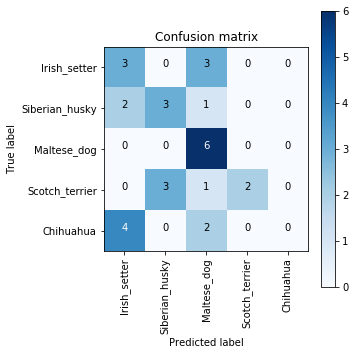

In [47]:
displayConfusionMatrix(y_test, y_pred, breed_names)

,Breed,PredictionRatio
0,Chihuahua,0.500000
1,Irish_setter,0.500000
2,Maltese_dog,1.000000
3,Scotch_terrier,0.333333
4,Siberian_husky,0.000000


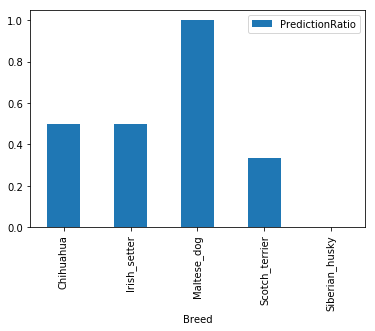

In [48]:
evaluatePerClass(y_test.values, y_pred)

### Gradient Boosting

In [49]:
gboost  =  GradientBoostingClassifier()
parameters = {'clf__n_estimators' : [10, 50, 100]}
gboost_grid, y_pred = evaluateClassifier(gboost, parameters, x_train, y_train, x_test, y_test)

Best params : {'clf__n_estimators': 100, 'visualbow__n_clusters': 100}
Classification accuracy: 53.33 % 
done in 3338.507s.


Confusion matrix, without normalization


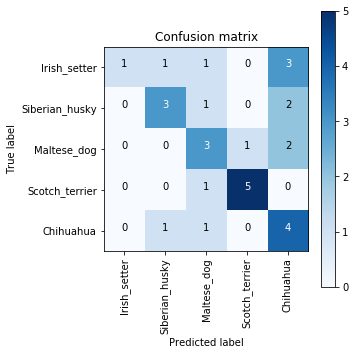

In [50]:
displayConfusionMatrix(y_test, y_pred, breed_names)

,Breed,PredictionRatio
0,Chihuahua,0.166667
1,Irish_setter,0.500000
2,Maltese_dog,0.500000
3,Scotch_terrier,0.833333
4,Siberian_husky,0.666667


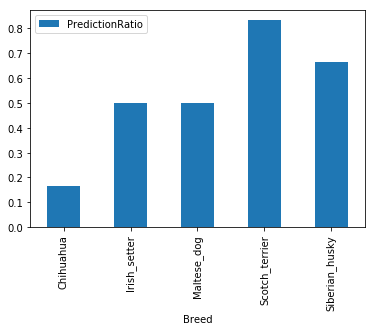

In [51]:
evaluatePerClass(y_test.values, y_pred)

### KNN

In [65]:
knn = KNeighborsClassifier(algorithm='auto')
parameters = {'clf__n_neighbors': np.arange(1,4,1)}
knn_grid, y_pred = evaluateClassifier(knn, parameters, x_train, y_train, x_test, y_test)

Best params : {'clf__n_neighbors': 3, 'visualbow__n_clusters': 100}
Classification accuracy: 33.33 % 
done in 3435.831s.


Confusion matrix, without normalization


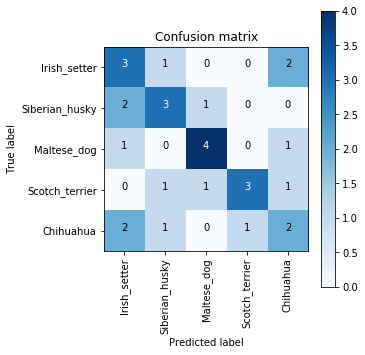

In [59]:
displayConfusionMatrix(y_test, y_pred, breed_names)

,Breed,PredictionRatio
0,Chihuahua,0.500000
1,Irish_setter,0.500000
2,Maltese_dog,0.666667
3,Scotch_terrier,0.500000
4,Siberian_husky,0.333333


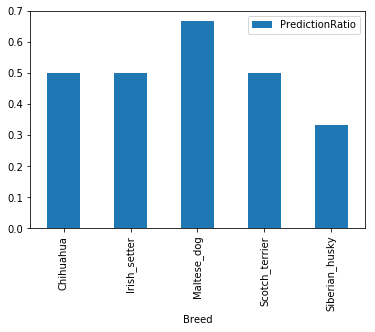

In [60]:
evaluatePerClass(y_test.values, y_pred)

In [64]:
np.arange(1,4,1)

array([1, 2, 3])